# Uncertainty propagation

Using the force on the sail example seen in class.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


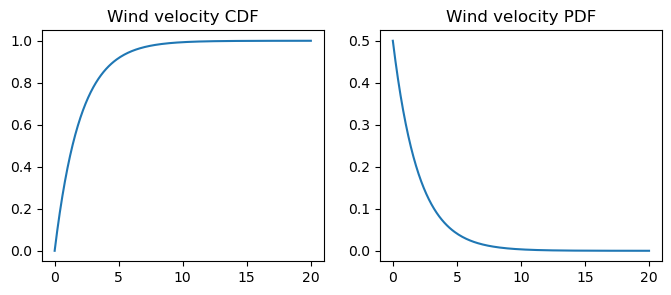

In [5]:
A = 7 # m^2, sail area
rho = 1.2 # air density kg/m^3
v0 = 2 # m/s mean wind speed 
beta = 1/v0 * np.sqrt(2/(rho*A))
from scipy.stats import expon
velocity_dist = expon(scale=v0) # input velocity is exponentially distributed

xvals = np.linspace(0.001, 20, 200)
fig, ax = plt.subplots(ncols=2, figsize=(8, 3))
ax[0].plot(xvals, velocity_dist.cdf(xvals))
ax[0].set_title('Wind velocity CDF')
ax[1].plot(xvals, velocity_dist.pdf(xvals))
ax[1].set_title('Wind velocity PDF')
plt.show()

In class we saw that the CDF and PDF of wind force can be computed analytically as:
$$ F_{Y}(y)=1-e^{-\beta \sqrt{y}} $$
$$ f_{Y}(y)=\frac{\beta}{2 \sqrt{y}} e^{-\beta \sqrt{y}}$$

In [64]:
# those were computed in class
def force_cdf(y):
    cdf_vals = np.where(y>0, 1.-np.exp(-beta*np.sqrt(y)), 0.)
    return cdf_vals

def force_pdf(y):
    pdf_vals = np.where(y>0, beta/(2*np.sqrt(y))*np.exp(-beta*np.sqrt(y)), 0.)
    return pdf_vals

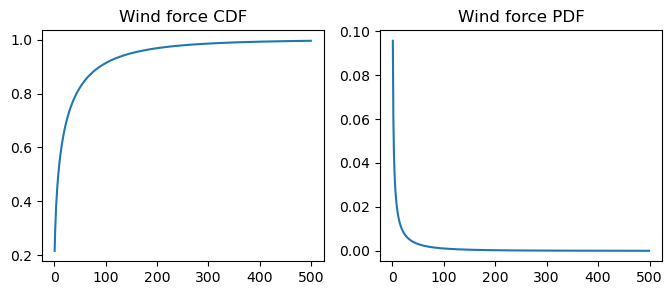

In [67]:
yvals = np.arange(1, 500, step=1)
fig, ax = plt.subplots(ncols=2, figsize=(8, 3))
ax[0].plot(yvals, force_cdf(yvals))
ax[0].set_title('Wind force CDF')
ax[1].plot(yvals, force_pdf(yvals))
ax[1].set_title('Wind force PDF')
plt.show()

In [34]:
from sympy import Symbol, sqrt, exp, integrate
y = Symbol('y')
integral_check = integrate(beta/(2*sqrt(y))*exp(-beta*sqrt(y)), (y, 0, np.inf))
print(integral_check)

1.00000000000000


In [18]:
from sympy import Symbol, sqrt, exp, integrate
y = Symbol('y')
expect_force = integrate(y*beta/(2*sqrt(y))*exp(-beta*sqrt(y)), (y, 0, np.inf))
print('Expected wind force = {:.1f} N'.format(expect_force))

var_force = integrate(y**2*beta/(2*sqrt(y))*exp(-beta*sqrt(y)), (y, 0, np.inf)) - expect_force**2
print('Variance of wind force = {:.1f} N^2'.format(var_force))

Expected wind force = 33.6 N
Variance of wind force = 5644.8 N^2


## Linearization

In [15]:
def func_h(x):
    return 1/2 * rho * A * x ** 2

def deriv_h(x, order=1):
    if order == 1:
        return rho * A * x
    elif order == 2:
        return rho * A

In [33]:
mean_x, var_x = velocity_dist.mean(), velocity_dist.var() # note mean is actually v0 and v0**2
print(mean_x, v0, var_x, v0**2)

first_order_approx_mean = func_h(mean_x)
print('Expected wind force by 1st order linearization = {:.1f} N'.format(first_order_approx_mean))

second_order_approx_mean = func_h(mean_x) + 1/2 * var_x * deriv_h(mean_x, order=2)
print('Expected wind force by 2nd order linearization = {:.1f} N'.format(second_order_approx_mean))

# Comment on accuracy of 2nd order...

2.0 2 4.0 4
Expected wind force by 1st order linearization = 16.8 N
Expected wind force by 2nd order linearization = 33.6 N


In [24]:
first_order_approx_var = var_x * deriv_h(mean_x, order=1) ** 2
print('Variance of wind force by 1st order linearization = {:.1f} N^2'.format(first_order_approx_var))

# Better approximations would include effect of 3rd and 4th order moments

Variance of wind force by 1st order linearization = 1129.0 N^2


## Monte Carlo sampling

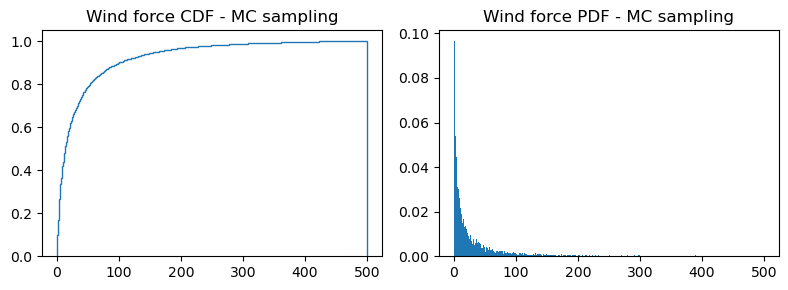

In [30]:
# sample from input RV
rvs_velocity = velocity_dist.rvs(10000)
# propagate RV through nonlinear function
#rvs_force = func_h(rvs_velocity) # broadcasting is faster
rvs_force = []
for x in rvs_velocity:
    y = func_h(x)
    rvs_force.append(y)

# Plot 
bins = np.arange(1, 500, step=1)
fig, ax = plt.subplots(ncols=2, figsize=(8, 3))
ax[0].hist(rvs_force, cumulative=True, histtype='step', density=True, bins=bins)
ax[0].set_title('Wind force CDF - MC sampling')
ax[1].hist(rvs_force, density=True, bins=bins)
ax[1].set_title('Wind force PDF - MC sampling')
fig.tight_layout()
plt.show()

In [31]:
print('Expected wind force by MC sampling with large nb of samples = {:.1f} N'.format(np.mean(rvs_force)))

Expected wind force by MC sampling with large nb of samples = 32.6 N


In [32]:
print('Variance of wind force by MC sampling with large nb of samples = {:.1f} N^2'.format(np.var(rvs_force)))

Variance of wind force by MC sampling with large nb of samples = 5171.5 N^2
